# Use edge coloring to reduce the depth of quantum circuits

This guide will show how to use the ``qiskit_addon_utils.coloring`` module to color edges of a coupling map and use the coloring to more efficiently place gates in a quantum circuit, leading to shallower circuits.

The point of edge-coloring a graph is to find a set of edge-colorings such that no two edges of the same color share a common node. For a quantum processor, this means that gates along like-colored edges may be run simultaneously. We can use this to define our circuit in a way that is more amenable to the hardware it should run on.

First, we will specify a backend and visualize its qubit topology.

In [1]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

backend = FakeSherbrooke()
coupling_map = backend.coupling_map

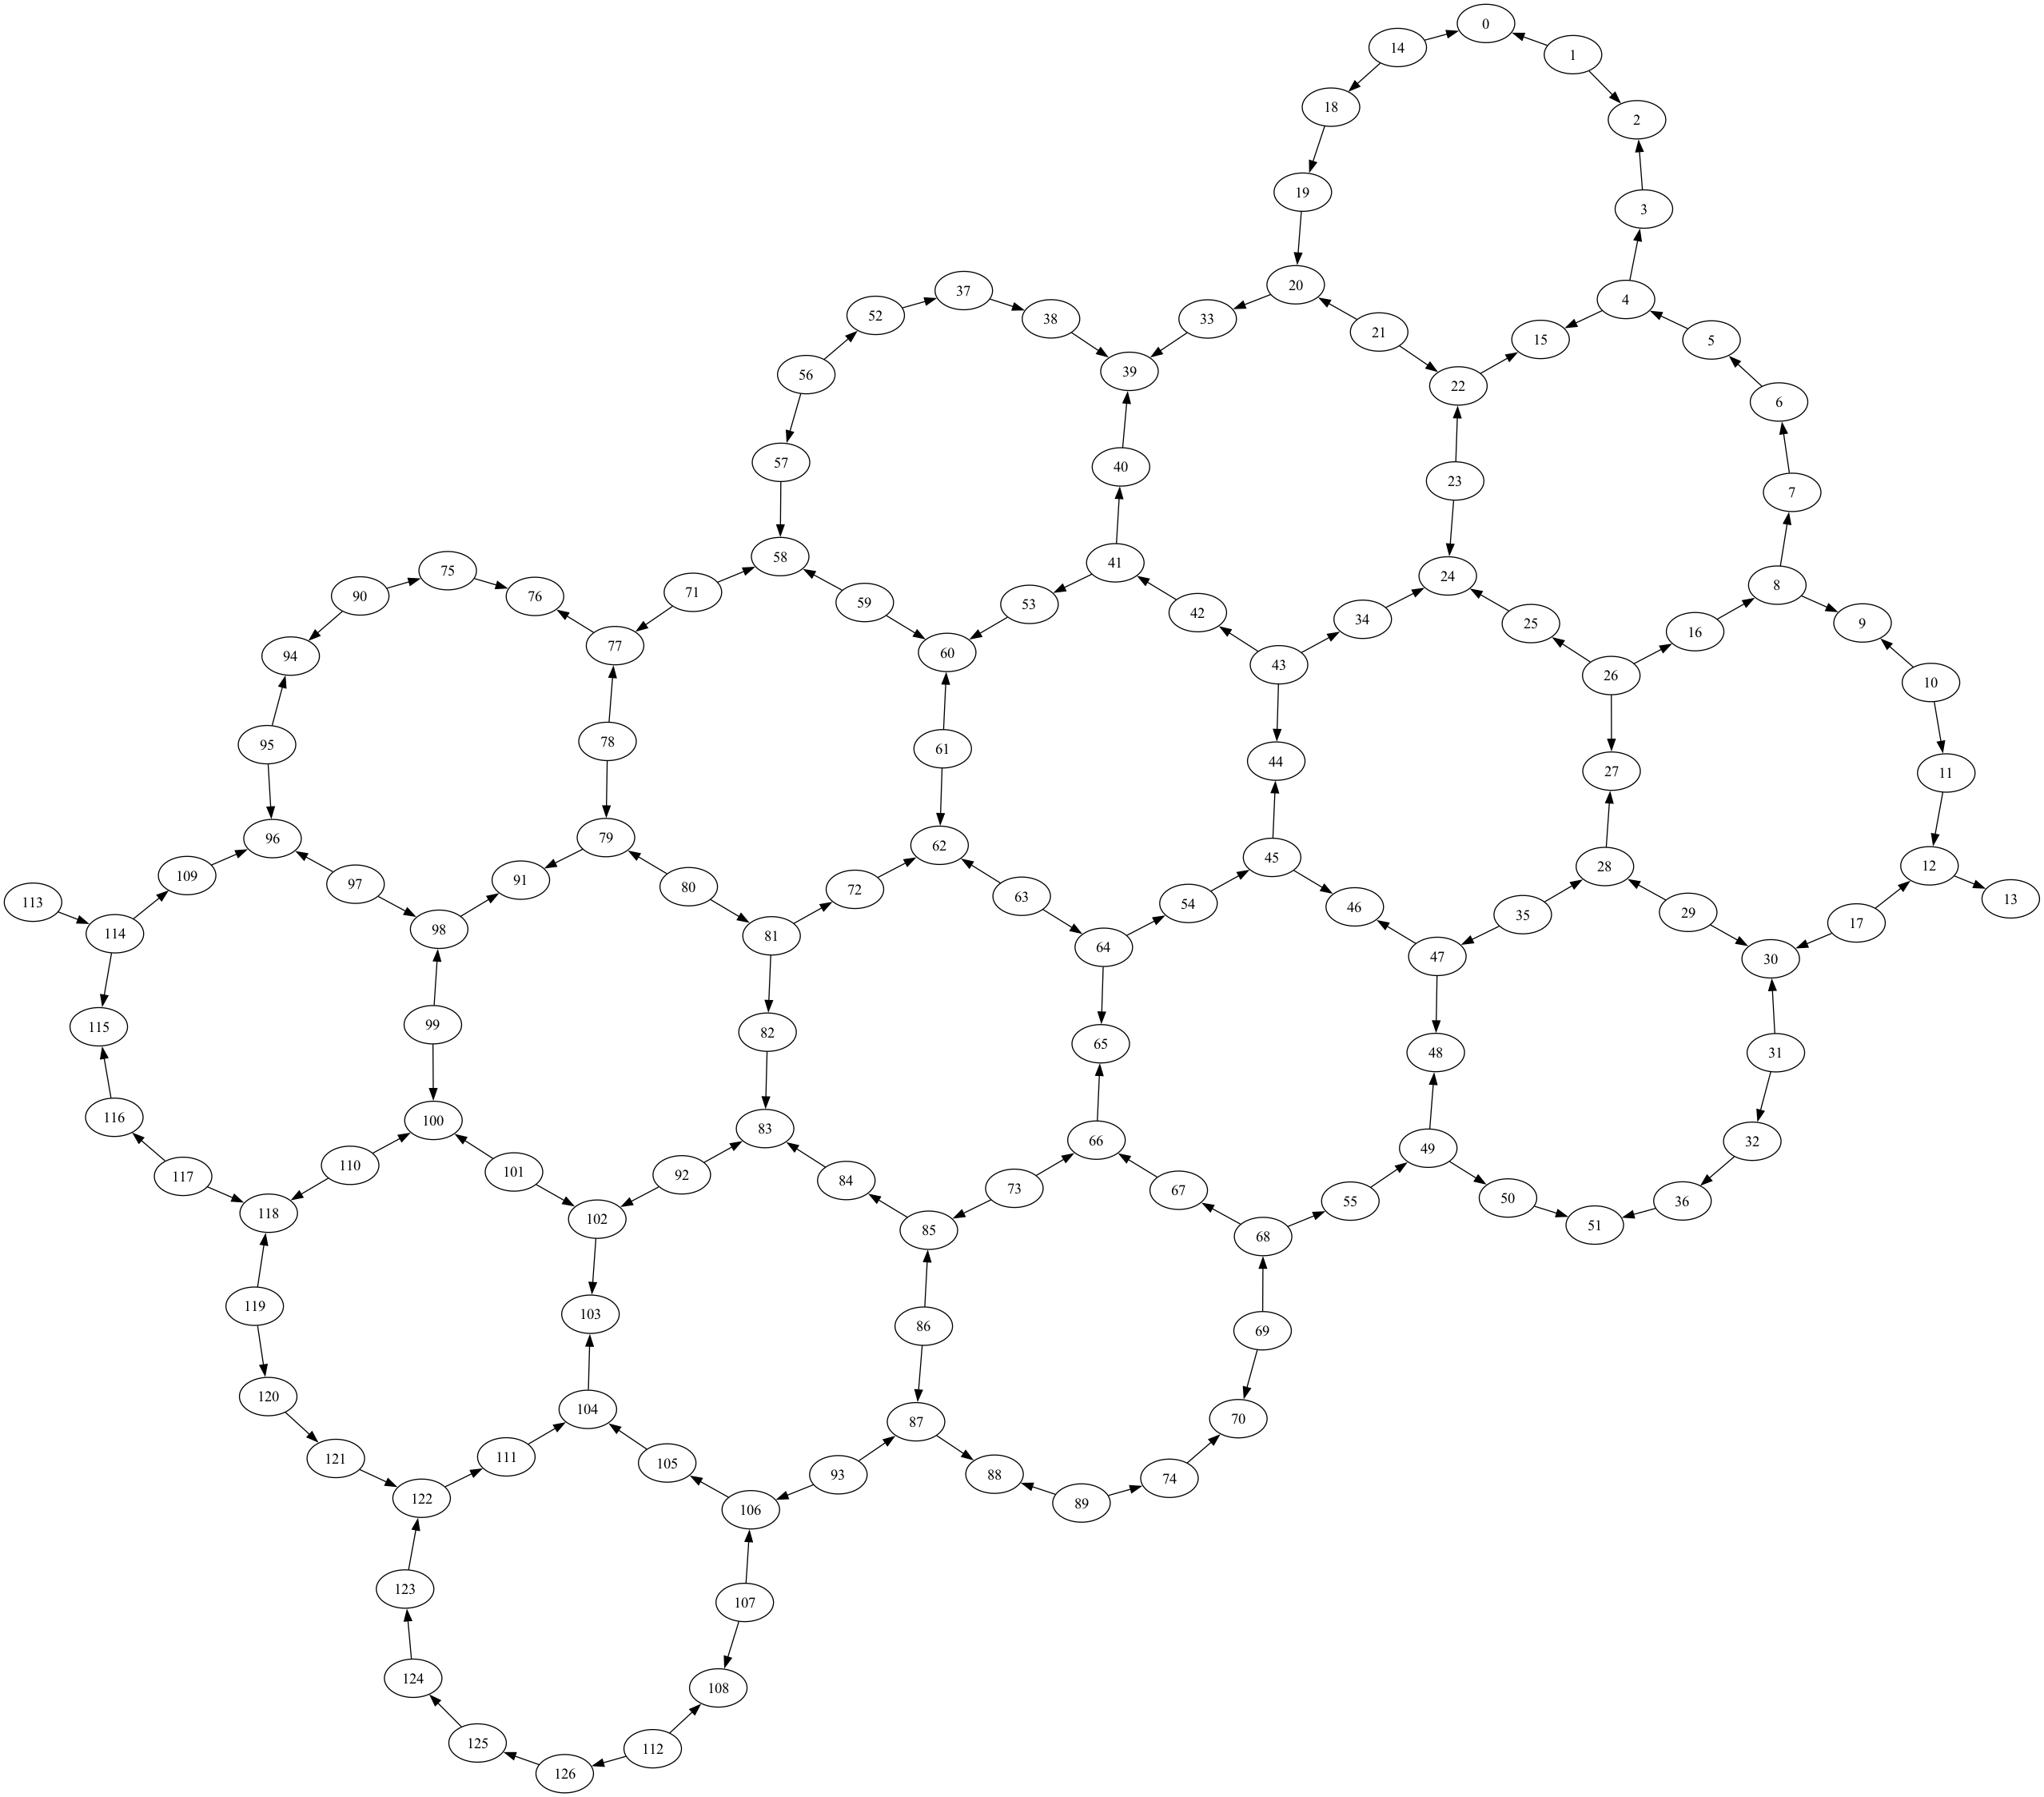

In [2]:
from rustworkx.visualization import graphviz_draw

graphviz_draw(coupling_map.graph, method="neato")

Next we use the ``auto_color_edges`` function to generate an edge coloring. This produces a dictionary mapping an edge to a color. We see that the edges in our heavy hex Eagle R3 devices can be 3-colored.

In [3]:
from qiskit_addon_utils.coloring import auto_color_edges
from rustworkx import PyDiGraph


def color_edge(edge):
    color_dict = {0: "red", 1: "green", 2: "blue"}
    return {"color": color_dict[edge]}


coloring = auto_color_edges(coupling_map)

# Create a colored graph for visualization
eagle_r3 = PyDiGraph()
eagle_r3.extend_from_weighted_edge_list(
    [(source, target, color) for ((source, target), color) in coloring.items()]
)
print(f"There are {len(coloring)} edges and {len(set(coloring.values()))} unique colors.")

There are 144 edges and 3 unique colors.


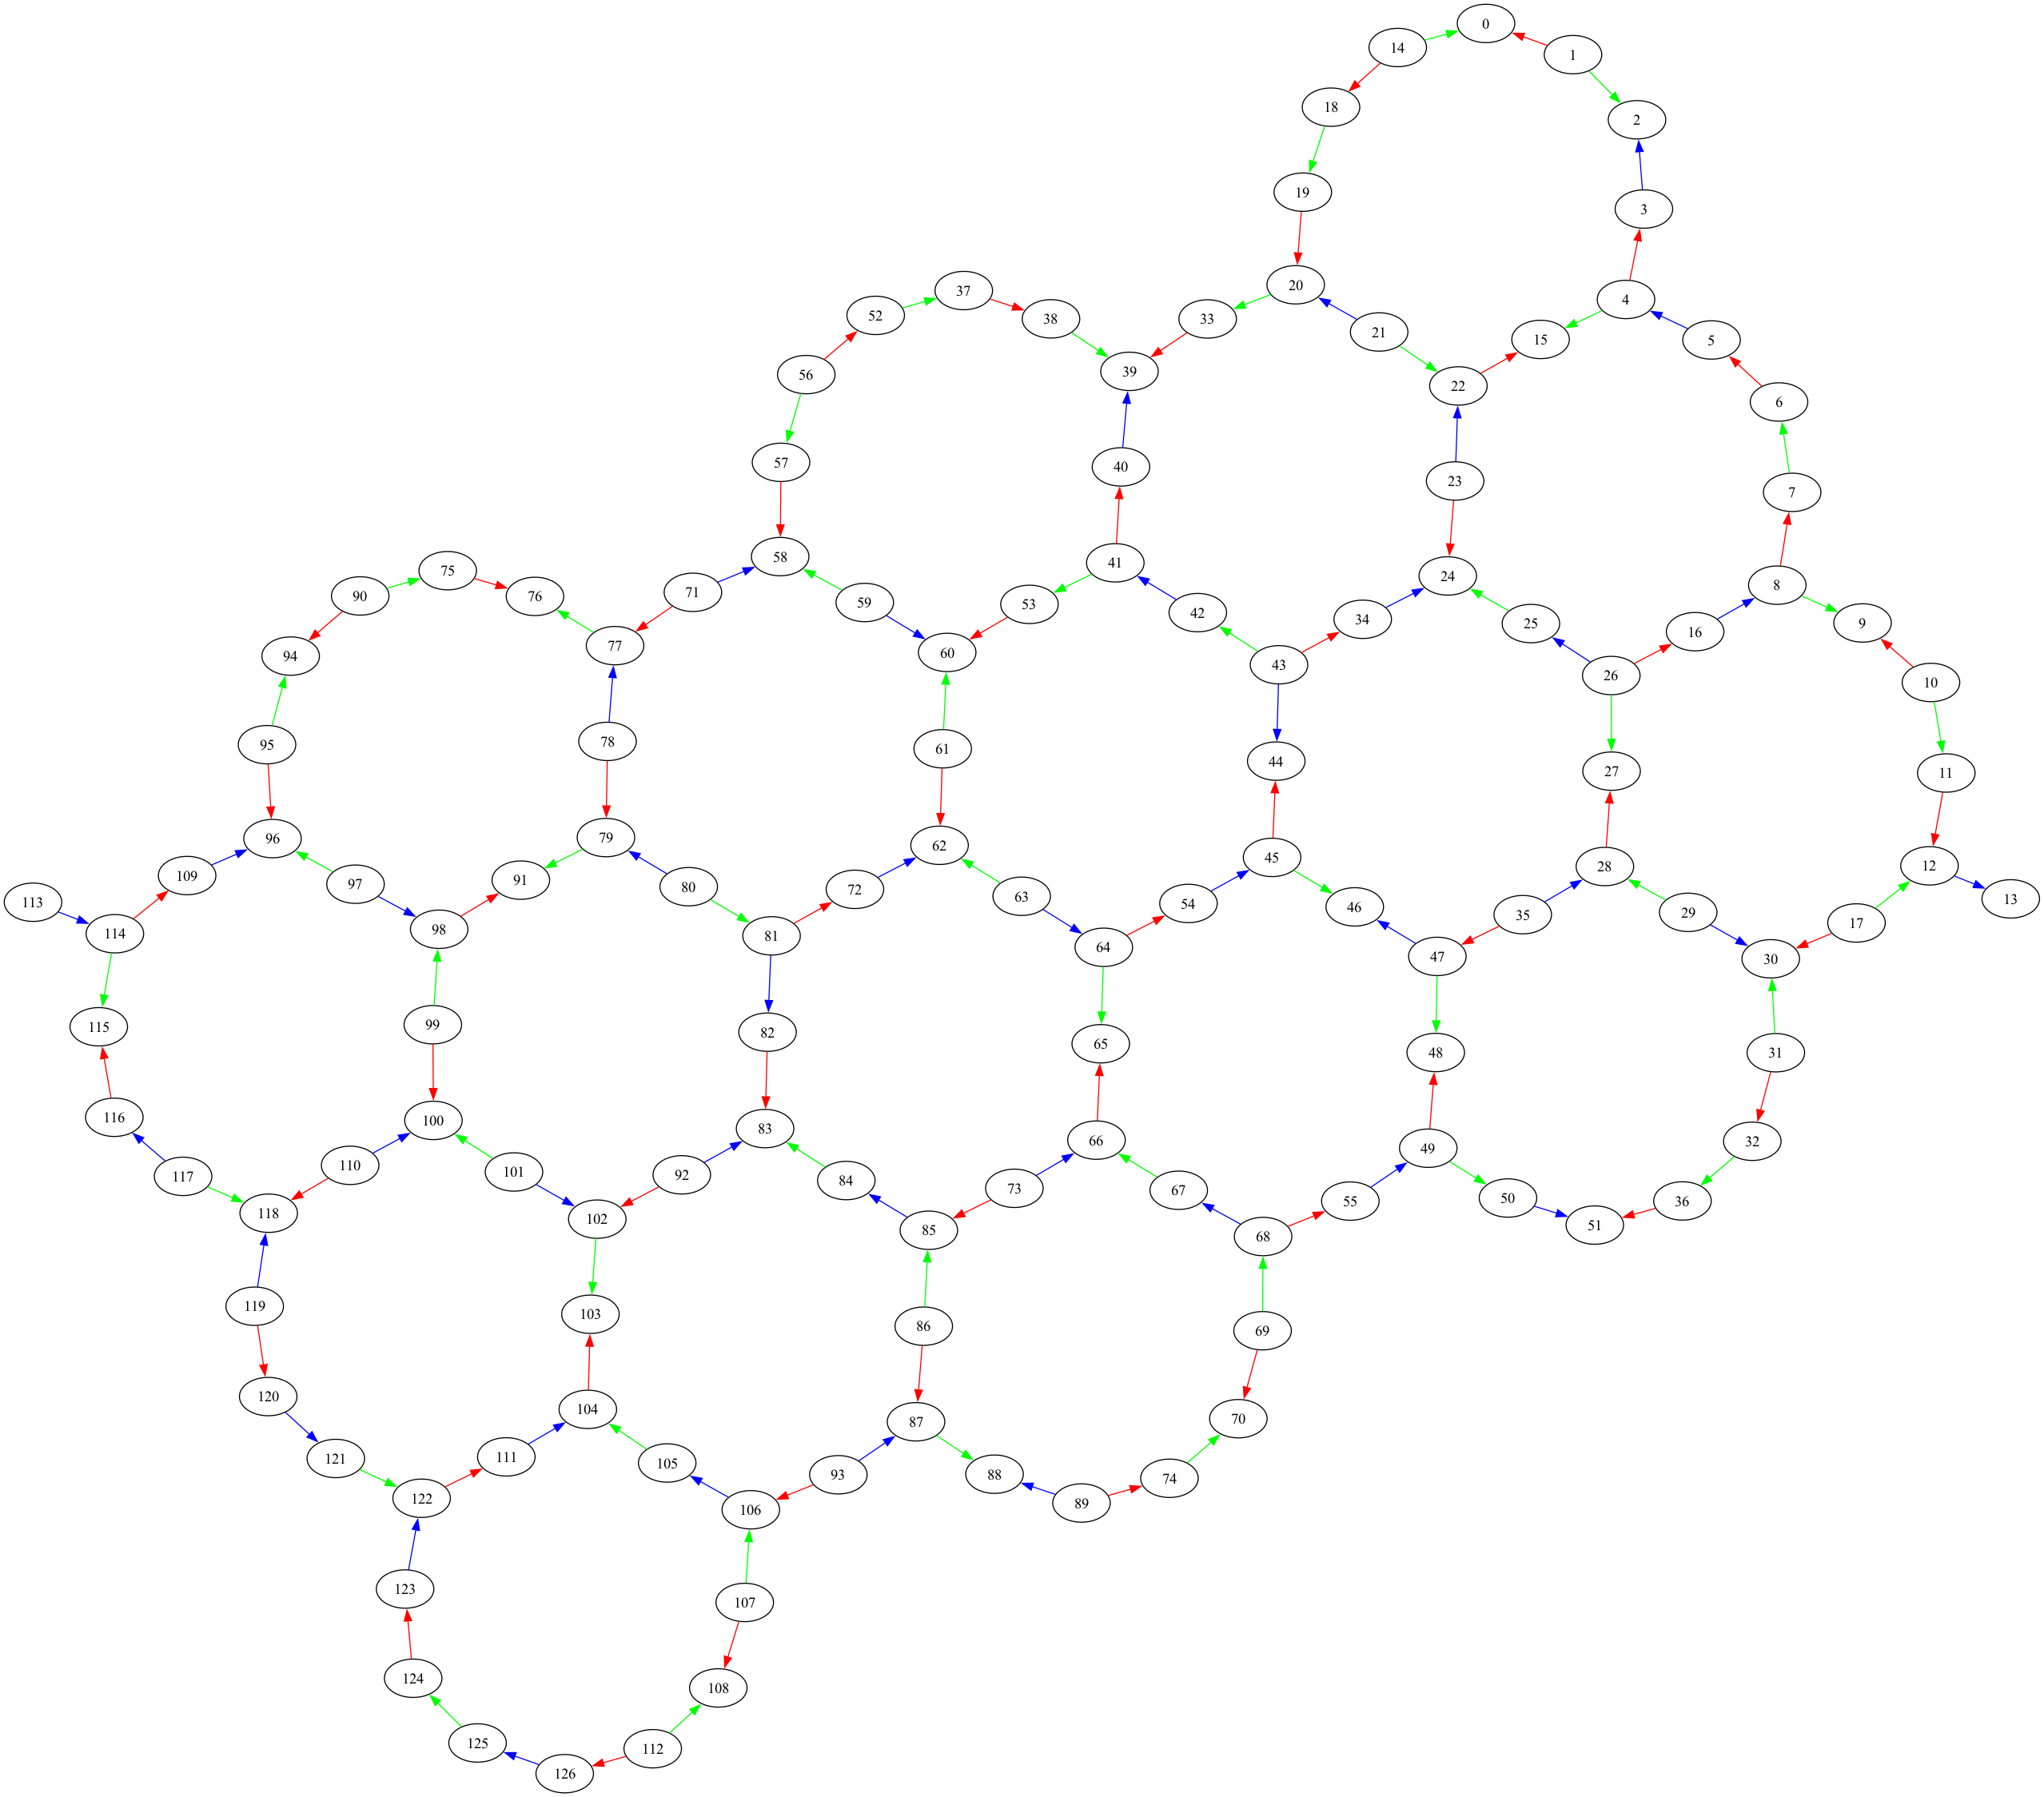

In [4]:
graphviz_draw(eagle_r3, edge_attr_fn=color_edge, method="neato")

Next, let's make a circuit with a ``CZGate`` on each edge and observe its depth. For this first circuit, we will just naively place a gate on each edge.

The circuit has depth: 37


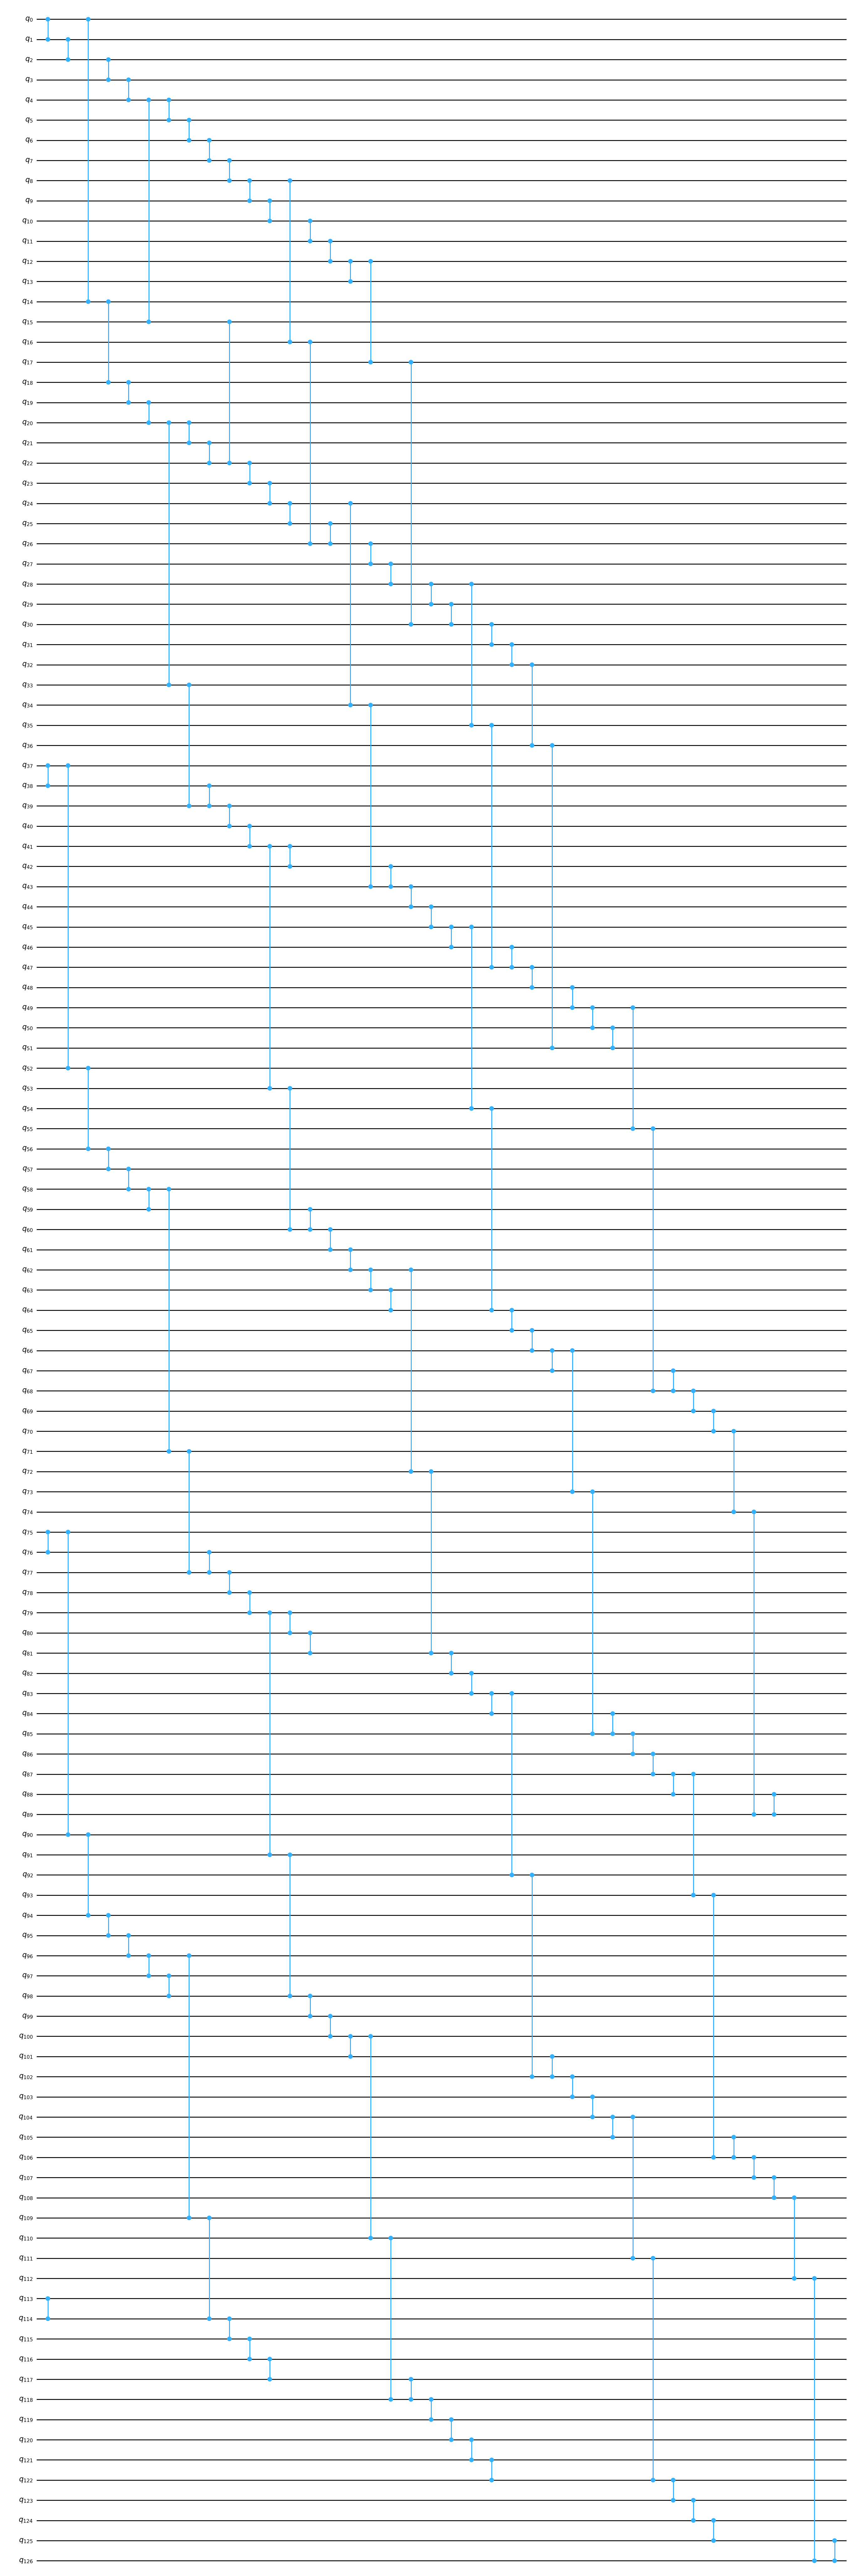

In [5]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(backend.num_qubits)
for edge in coupling_map.graph.edge_list():
    circuit.cz(edge[0], edge[1])
print(f"The circuit has depth: {circuit.depth()}")
circuit.draw("mpl", fold=-1)

Now let's place all of the gates of a given color at the same time. We can see the depth is reduced from 37 to 3. This is because we can take advantage of the fact that all gates on a given color can run at the same time.

The circuit has depth: 3


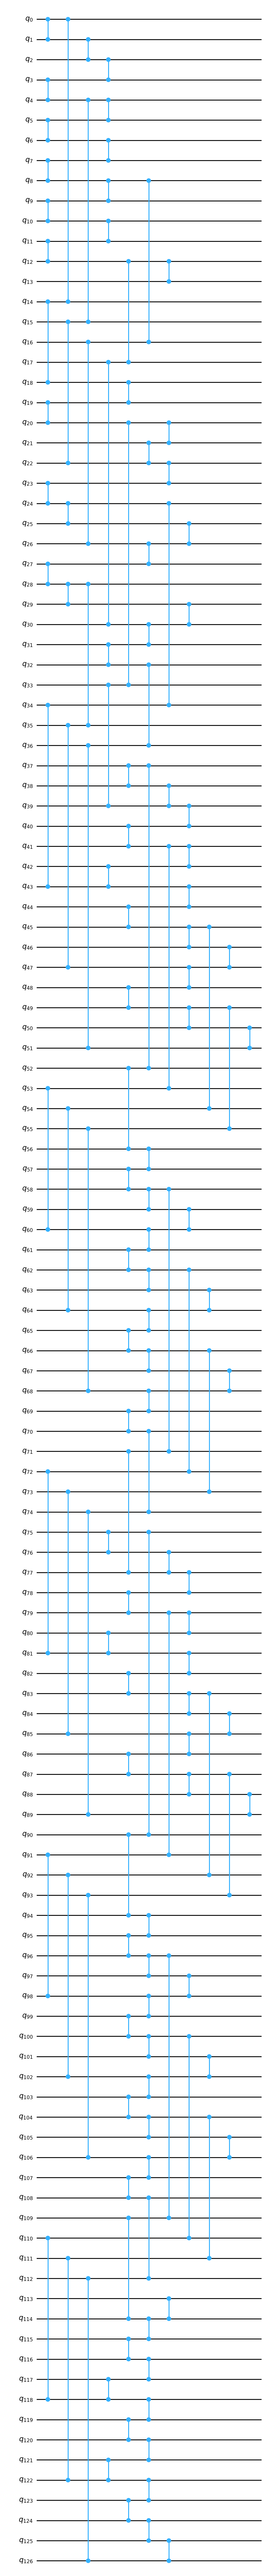

In [6]:
from collections import defaultdict

circuit = QuantumCircuit(backend.num_qubits)

color_to_edge = defaultdict(list)
for edge, color in coloring.items():
    color_to_edge[color].append(edge)
for edges in color_to_edge.values():
    for edge in edges:
        circuit.cz(edge[0], edge[1])
print(f"The circuit has depth: {circuit.depth()}")
circuit.draw("mpl", fold=-1)